<img src="./img/banner.png">

# Proyecto 1

1. Carga y exploración de datos.

    1.1. Importación de librerias.
    
    1.2. Carga de datos.
    
    1.3. Exploración.
    
2. Limpieza y preparación de los datos.

    2.1. Datos Nulos.

    2.2. Tipo adecuado de cada atributo.
    
    2.3. Selección de atributos.
        
3. Preparacion previa a los modelos.

    3.1. Tokenización.
    
    3.2. Stopwords.
    
    3.3. Analisis de sentimientos.

4. Modelos

    4.1. The multinomial Naive Bayes classifier.
    
    4.2. C-Support Vector Classification.
    
    4.3. SGD Classifier.
    

## 1. Carga y exploración de datos.

### 1.1. Importación de librerias.

In [1]:
# Librerías para manejo de datos
import pandas as pd
import numpy as np
import string
import re


# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from scipy.spatial.distance import cosine

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.linear_model import SGDClassifier
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV


#Librerías para la visualización
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import style


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



In [2]:
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelomarcetty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# carga de los datos
# csv -> dataFrame
df_reviews = pd.read_csv('./datos/kindle_reviews.csv', sep=',', encoding = 'utf-8' )

### 1.3. Exploración.

In [4]:
#cantidad de datos y numero de variables
df_reviews.shape

(982619, 10)

In [5]:
# mostrar las 5 primeras 982597
df_reviews.head(5)

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


In [6]:
# ver todos los tipos de variables 
df_reviews.dtypes

Unnamed: 0         int64
asin              object
helpful           object
overall            int64
reviewText        object
reviewTime        object
reviewerID        object
reviewerName      object
summary           object
unixReviewTime     int64
dtype: object

In [7]:
#cantidad de datos nulos
df_reviews.isnull().sum()

Unnamed: 0           0
asin                 0
helpful              0
overall              0
reviewText          22
reviewTime           0
reviewerID           0
reviewerName      3816
summary              1
unixReviewTime       0
dtype: int64

## 2. Limpieza y preparación de los datos.

### 2.1. Datos Nulos.

Primero procederemos a borrar los datos nulos de la columna **reviewText** con 22 nulos. Debido a que esta columna es de vital importancia, dado que son las reviews de determinado libros, los datos en ella son unicos, entonces es imposible saber el valor de esta columna.

In [8]:
df_reviews.dropna(subset = ["reviewText"], inplace=True)

La columna **reviewerName*** posee 3816 datos nulos. Esta columna hace referencia al nombre dado a determinada review. Debido a que esta columna posee una cantidad considerable de datos, se determina no borrar estos registro, pero si eliminar la columna, dado la cantidad de registros y el poco  aporte que pueda dar el nombre de la review a los modelos.

In [9]:
del df_reviews['reviewerName']

Finalmente para la columna de **summary** que posee un dato nulo, se considera borrarla, debido a que es un dado desconocido y la cantidad de nulos no tienen un impacto significativo en el modelo.

In [10]:
df_reviews.dropna(subset = ["summary"], inplace=True)

In [11]:
# cantidad de nulos
df_reviews.isnull().sum()

Unnamed: 0        0
asin              0
helpful           0
overall           0
reviewText        0
reviewTime        0
reviewerID        0
summary           0
unixReviewTime    0
dtype: int64

### 2.2. Tipo adecuado de cada atributo.

In [12]:
df_reviews.dtypes

Unnamed: 0         int64
asin              object
helpful           object
overall            int64
reviewText        object
reviewTime        object
reviewerID        object
summary           object
unixReviewTime     int64
dtype: object

La columna **reviewTime** es la fecha de creacion de el review y es de tipo date, entonces la convertiremos a su tipo.

In [13]:
df_reviews['reviewTime'] = df_reviews['reviewTime'].astype('datetime64[ns]')

In [14]:
df_reviews.dtypes

Unnamed: 0                 int64
asin                      object
helpful                   object
overall                    int64
reviewText                object
reviewTime        datetime64[ns]
reviewerID                object
summary                   object
unixReviewTime             int64
dtype: object

### 2.3. Selección de atributos.

Debido a que el objetivo del proyecto es encontrar la utilidad de las reviews de los libros, se considera de  utilidad  en un primer acercamientos las columnas de **overall**  **asin** - **reviewerID** - **reviewText** para el analisis, las cuales perteneces al puntaje del libro, id del libro, el id del reviewer y al texto del review respectivamente. En estas columnas se encuentra la informacion util para el procesamiento del lenguaje natural. Por tal motivo se descarta el uso de todas las otras columnas.

In [15]:
df_reviews_text = df_reviews.copy()

In [16]:
del df_reviews_text['Unnamed: 0']
#del df_reviews_text['asin']
del df_reviews_text['helpful']
#del df_reviews_text['overall']
del df_reviews_text['reviewTime']
#del df_reviews_text['reviewerID']
del df_reviews_text['summary']
del df_reviews_text['unixReviewTime']

In [17]:
df_reviews_text.describe()

,overall
count,982596.000000
mean,4.347791
std,0.955061
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## 3. Preparacion previa a los modelos.

Debido al alto volumen de datos y a las limitaciones computacionales que tenemos, se decide solo usar el 5% del total de los datos, que corresponde a 49130 registros. 

In [18]:
#n=50 numero de muestras
#frac=0.2 porcentaje de la muestra
#random_state: siempre extrae las mismas filas
df_reviews_text_m = df_reviews_text.sample(frac=0.05, random_state=1)


In [19]:
df_reviews_text_m.shape

(49130, 4)

In [20]:
df_reviews_text_m.head(4)

,asin,overall,reviewText,reviewerID
186860,B007FIQMHU,5,A unique hero. A strong character who was sure...,A36T5VDRP7B7F
248831,B008DQLNQI,2,If I paid I'd want a refund .. the characters ...,AUD1LIFNPHREC
14010,B003A022GW,5,I enjoyed this second installment more than th...,A3AB3Z5R69HWLS
907091,B00JVHPVZ2,5,This book tells you all about the different ki...,AIIC0G14GVVV


### 3.1. Tokenización

La tokenización permite dividir frases u oraciones en palabras. Con el fin de desglozar las palabras correctamente para el posterior análisis.

In [21]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


Se busca que mediante esta funcion, se limpie y se tokenice cada review.

In [22]:
# Se aplica la función de limpieza y tokenización
# ==============================================================================
df_reviews_text_m['texto_tokenizado'] = df_reviews_text_m['reviewText'].apply(lambda x: limpiar_tokenizar(x))
df_reviews_text_m[['reviewText', 'texto_tokenizado']].head()

,reviewText,texto_tokenizado
186860,A unique hero. A strong character who was sure...,"[unique, hero, strong, character, who, was, su..."
248831,If I paid I'd want a refund .. the characters ...,"[if, paid, want, refund, the, characters, are,..."
14010,I enjoyed this second installment more than th...,"[enjoyed, this, second, installment, more, tha..."
907091,This book tells you all about the different ki...,"[this, book, tells, you, all, about, the, diff..."
334871,I am fast becoming a fan of Wanda B. Campbell....,"[am, fast, becoming, fan, of, wanda, campbell,..."


Para entender que caracteriza cada palabras, con qué frecuencia, así como el significado de las mismas.

In [23]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
df_reviews_text_m_tidy = df_reviews_text_m.explode(column='texto_tokenizado')
df_reviews_text_m_tidy = df_reviews_text_m_tidy.drop(columns='reviewText')
df_reviews_text_m_tidy = df_reviews_text_m_tidy.rename(columns={'texto_tokenizado':'token'})
df_reviews_text_m_tidy.head(4)

,asin,overall,reviewerID,token
186860,B007FIQMHU,5,A36T5VDRP7B7F,unique
186860,B007FIQMHU,5,A36T5VDRP7B7F,hero
186860,B007FIQMHU,5,A36T5VDRP7B7F,strong
186860,B007FIQMHU,5,A36T5VDRP7B7F,character


In [24]:
# Palabras totales utilizadas
# ==============================================================================
print('--------------------------')
print('Palabras totales usadas en cada libro')
print('--------------------------')
df_reviews_text_m_tidy.groupby(by='asin')['token'].count()

--------------------------
Palabras totales usadas en cada libro
--------------------------


asin
B000F83SZQ     52
B000FA64PA     38
B000FBFMVG    275
B000FC2MB8    405
B000JMKU0Y     61
             ... 
B00LZFHL7Y    485
B00LZKMXBI    287
B00M029T4O    213
B00M0RE7CS    138
B00M13FNSS     71
Name: token, Length: 27953, dtype: int64

In [25]:
# Palabras totales utilizadas 
# ==============================================================================
print('--------------------------')
print('Palabras totales usadas de cada reviewer')
print('--------------------------')
df_reviews_text_m_tidy.groupby(by='reviewerID')['token'].count()

--------------------------
Palabras totales usadas de cada reviewer
--------------------------


reviewerID
A00207583M69Q8KX3BOFQ     19
A00463782V7TKAP9EMNL      45
A006458827ALF2J23JJTO     56
A0090953K7LNUG6UPMI6      18
A0099735VDZ3HDCAAYKL     153
                        ... 
AZZMO52V8WZ68            175
AZZN6N74U2PA5             76
AZZPTYC0F6FWA             43
AZZQRGF0PC6WF            431
AZZW5NCOD8IA0             94
Name: token, Length: 27875, dtype: int64

In [26]:
# Palabras distintas utilizadas 
# ==============================================================================
print('----------------------------')
print('Palabras distintas usadas en cada libro')
print('----------------------------')
df_reviews_text_m_tidy.groupby(by='asin')['token'].nunique()

----------------------------
Palabras distintas usadas en cada libro
----------------------------


asin
B000F83SZQ     44
B000FA64PA     33
B000FBFMVG    176
B000FC2MB8    227
B000JMKU0Y     49
             ... 
B00LZFHL7Y    237
B00LZKMXBI    167
B00M029T4O    132
B00M0RE7CS    100
B00M13FNSS     59
Name: token, Length: 27953, dtype: int64

In [27]:
# Palabras distintas utilizadas 
# ==============================================================================
print('----------------------------')
print('Palabras distintas usadas por cada reviewer')
print('----------------------------')
df_reviews_text_m_tidy.groupby(by='reviewerID')['token'].nunique()

----------------------------
Palabras distintas usadas por cada reviewer
----------------------------


reviewerID
A00207583M69Q8KX3BOFQ     16
A00463782V7TKAP9EMNL      38
A006458827ALF2J23JJTO     43
A0090953K7LNUG6UPMI6      16
A0099735VDZ3HDCAAYKL      86
                        ... 
AZZMO52V8WZ68            114
AZZN6N74U2PA5             61
AZZPTYC0F6FWA             37
AZZQRGF0PC6WF            228
AZZW5NCOD8IA0             67
Name: token, Length: 27875, dtype: int64

In [28]:
# Top 5 palabras más utilizadas por cada libro
# ==============================================================================
df_reviews_text_m_tidy.groupby(['asin','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('asin') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

asin    token  count
asin                                          
B000F83SZQ 32       B000F83SZQ      the      5
           0        B000F83SZQ      and      2
           12       B000F83SZQ       in      2
           40       B000F83SZQ      was      2
           30       B000F83SZQ  someone      2
...                        ...      ...    ...
B00M13FNSS 2930785  B00M13FNSS      was      4
           2930775  B00M13FNSS     that      3
           2930731  B00M13FNSS      and      3
           2930737  B00M13FNSS     damn      2
           2930770  B00M13FNSS      she      2

[139706 rows x 3 columns]

In [29]:
# Top 5 palabras más utilizadas por cada reviewer
# ==============================================================================
df_reviews_text_m_tidy.groupby(['reviewerID','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('reviewerID') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

reviewerID      token  count
reviewerID                                                            
A00207583M69Q8KX3BOFQ 5        A00207583M69Q8KX3BOFQ  enjoyable      2
                      7        A00207583M69Q8KX3BOFQ      great      2
                      8        A00207583M69Q8KX3BOFQ         is      2
                      0        A00207583M69Q8KX3BOFQ        are      1
                      1        A00207583M69Q8KX3BOFQ      boxed      1
...                                              ...        ...    ...
AZZW5NCOD8IA0         2744215          AZZW5NCOD8IA0        the      6
                      2744212          AZZW5NCOD8IA0         so      4
                      2744165          AZZW5NCOD8IA0        and      3
                      2744196          AZZW5NCOD8IA0      loved      3
                      2744192          AZZW5NCOD8IA0         is      3

[139277 rows x 3 columns]

### 3.2. Stopwords

In [30]:
# Obtención de listado de stopwords del inglés
# ==============================================================================
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [31]:
# Filtrado para excluir stopwords
# ==============================================================================
df_reviews_text_m_tidy = df_reviews_text_m_tidy[~(df_reviews_text_m_tidy["token"].isin(stop_words))]

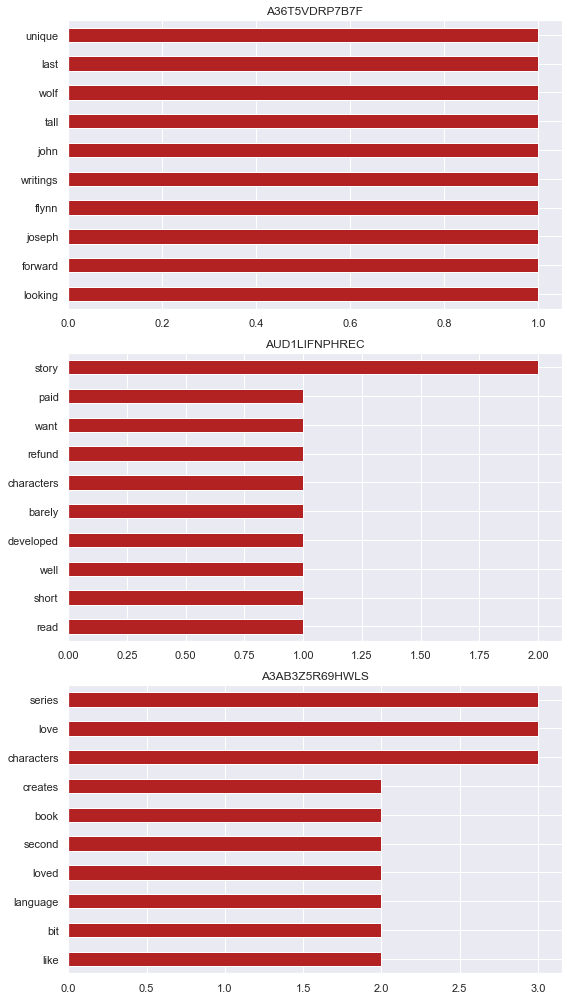

In [32]:
# Top 10 palabras por autor (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(8, 14))

for i, autor in enumerate(df_reviews_text_m_tidy.reviewerID.unique()):
    df_temp = df_reviews_text_m_tidy[df_reviews_text_m_tidy.reviewerID == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)
    if (i>=2) :
        break

fig.tight_layout()

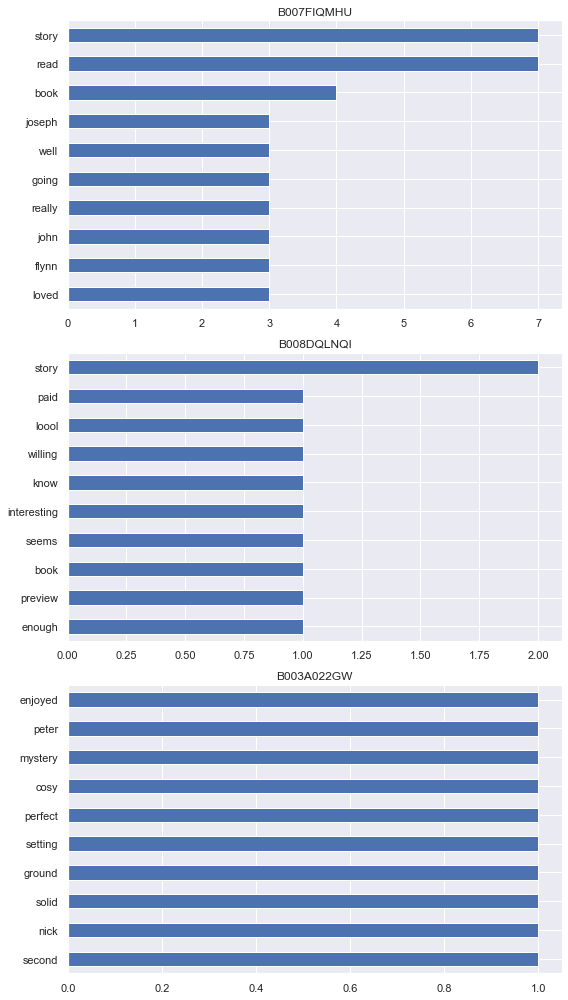

In [33]:
# Top 10 palabras por libro (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(8, 14))

for i, autor in enumerate(df_reviews_text_m_tidy.asin.unique()):
    df_temp = df_reviews_text_m_tidy[df_reviews_text_m_tidy.asin == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)
    if (i>=2) :
        break
fig.tight_layout()

### 3.3. Analisis de sentimientos

A continuación se procede a descargar un diccionario que asigna a cada palabra un numero. Dependiendo del sentimiento de esta palabra puede ser negativa o positiva, entonces para conocer el sentimiento de una review la suma de las palabras determinan si la review es positiva o negariva.

In [34]:
# Descarga lexicon sentimientos
# ==============================================================================
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.sample(6)

,termino,sentimiento
238,attracts,1
491,cheerless,-2
3110,unaware,-2
1030,drag,-1
2910,struck,-1
309,benefactor,2


In [35]:
# Sentimiento promedio
# ==============================================================================
reviews_sentimientos = pd.merge(
                            left     = df_reviews_text_m_tidy,
                            right    = lexicon,
                            left_on  = "token", 
                            right_on = "termino",
                            how      = "inner"
                      )

reviews_sentimientos = reviews_sentimientos.drop(columns = "termino")

# Se suman los sentimientos de las palabras que forman cada review.
reviews_sentimientos = reviews_sentimientos[["reviewerID", "asin", "sentimiento"]] \
                      .groupby(["reviewerID", "asin"])\
                      .sum().reset_index()
reviews_sentimientos.tail(12)

,reviewerID,asin,sentimiento
48497,AZZMO52V8WZ68,B00E3F0S4Q,8
48498,AZZMO52V8WZ68,B00ETBK3MG,10
48499,AZZMO52V8WZ68,B00KI1SJJK,8
48500,AZZN6N74U2PA5,B004P8K2HY,7
48501,AZZN6N74U2PA5,B00B6JFKNG,0
48502,AZZN6N74U2PA5,B00DY91L70,4
48503,AZZPTYC0F6FWA,B00466H3MM,15
48504,AZZQRGF0PC6WF,B006KZ5M84,-5
48505,AZZQRGF0PC6WF,B008I7DO96,0
48506,AZZQRGF0PC6WF,B00FQ5D27C,-1


Comprobamos el funcionamiento, relacionando el review con el numero de su sentimiento.

In [36]:
#df1 = df[(df.a != -1) & (df.b != -1)]
#pd.set_option("display.max_rows", 15, "display.max_columns", 19) #en caso de visualizar cantidad n de datos

# 48503	AZZPTYC0F6FWA	B00466H3MM	15
dfPruenaC = df_reviews[(df_reviews['reviewerID']=='AZZPTYC0F6FWA') & (df_reviews['asin']=='B00466H3MM') ]
print(dfPruenaC['reviewText'].values)


["I was pleasantly surprised this story was so good. It's sci-fi aspect would not be my usual read but I liked this one a lot. Great characters,strong dom male and sub female... I liked it.Hopefully Stephanie Snow is not a one hit wonder...I want more!"]


## 4. Modelos

### 4.1. The multinomial Naive Bayes classifier. 

In [37]:
df_reviews_text_m.head()

,asin,overall,reviewText,reviewerID,texto_tokenizado
186860,B007FIQMHU,5,A unique hero. A strong character who was sure...,A36T5VDRP7B7F,"[unique, hero, strong, character, who, was, su..."
248831,B008DQLNQI,2,If I paid I'd want a refund .. the characters ...,AUD1LIFNPHREC,"[if, paid, want, refund, the, characters, are,..."
14010,B003A022GW,5,I enjoyed this second installment more than th...,A3AB3Z5R69HWLS,"[enjoyed, this, second, installment, more, tha..."
907091,B00JVHPVZ2,5,This book tells you all about the different ki...,AIIC0G14GVVV,"[this, book, tells, you, all, about, the, diff..."
334871,B009WI84A4,5,I am fast becoming a fan of Wanda B. Campbell....,A31D1WWJQUVBVF,"[am, fast, becoming, fan, of, wanda, campbell,..."


In [38]:
data = df_reviews_text_m[['overall' , 'reviewText' , 'texto_tokenizado']]
data.head()

,overall,reviewText,texto_tokenizado
186860,5,A unique hero. A strong character who was sure...,"[unique, hero, strong, character, who, was, su..."
248831,2,If I paid I'd want a refund .. the characters ...,"[if, paid, want, refund, the, characters, are,..."
14010,5,I enjoyed this second installment more than th...,"[enjoyed, this, second, installment, more, tha..."
907091,5,This book tells you all about the different ki...,"[this, book, tells, you, all, about, the, diff..."
334871,5,I am fast becoming a fan of Wanda B. Campbell....,"[am, fast, becoming, fan, of, wanda, campbell,..."


In [39]:
def overall_threshold(value):
    # taking threshold here as 3
    if(value == 1 or value == 2 or value == 3):
        return 0
    else:
        return 1

data.overall = data.overall.apply(overall_threshold)

In [40]:
# default random state is 0
X_train, x_test, Y_train, y_test = train_test_split(data.reviewText, data.overall, test_size = 0.2, random_state = 0) 

In [41]:
CV = CountVectorizer()
X_train_overall = CV.fit_transform(X_train)
x_test_overall = CV.transform(x_test)

In [42]:
print(X_train_overall.shape)
print(x_test_overall.shape)

(39304, 56991)
(9826, 56991)


In [43]:
# Multinomial Naive Bayes is used particularly for documents, which explicitly models the count of words and related 
# calculations rather than just stating the presence or absence of a particular word

mnb = MultinomialNB()
mnb.fit(X_train_overall, Y_train)
mnb_results = mnb.predict(x_test_overall)

In [44]:
accuracy_score(y_test, mnb_results)

0.8887645023407287

In [45]:
classification_ans = classification_report(y_test, mnb_results)
print(classification_ans)

              precision    recall  f1-score   support

           0       0.67      0.60      0.63      1559
           1       0.93      0.94      0.93      8267

    accuracy                           0.89      9826
   macro avg       0.80      0.77      0.78      9826
weighted avg       0.88      0.89      0.89      9826



In [46]:
# Confusion matrix consists of true negatives, false positives, false negatives, true positives 
print(confusion_matrix(y_test, mnb_results))

[[ 935  624]
 [ 469 7798]]


### 4.2. C-Support Vector Classification.

In [47]:
# this code is very time-taking, optimization techniques can be used

clf = SVC()
clf.fit(X_train_overall, Y_train) 
svm = clf.predict(x_test_overall)

In [48]:
accuracy_score(y_test, svm)

0.8818440871158152

In [49]:
classification_ans = classification_report(y_test, svm)
print(classification_ans)

              precision    recall  f1-score   support

           0       0.83      0.32      0.46      1559
           1       0.88      0.99      0.93      8267

    accuracy                           0.88      9826
   macro avg       0.86      0.65      0.70      9826
weighted avg       0.88      0.88      0.86      9826



### 4.3. SGD Classifier.

In [50]:

clf = SGDClassifier()

distributions = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    alpha=uniform(loc=1e-6, scale=1e-4)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=5,
    n_iter=50
)


In [51]:
random_search_cv.fit(X_train_overall, Y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

Best params: {'alpha': 8.816734917631037e-05, 'penalty': 'elasticnet'}
Best score: 0.8891461600784367
